In [1]:
import numpy as np

from models.CM1DLayers import IlluminationPeakLayer, ZNCCLayer, IFFTReconLayer
from dataset.dataset import SampleLabels
from utils.torch_utils import *
from felipe_utils.research_utils.signalproc_ops import gaussian_pulse

import matplotlib.pyplot as plt
import matplotlib
import yaml

In [2]:
rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = 10

counts = torch.Tensor([1000] * 10)
sbrs = torch.Tensor([1.0] * 10)
peak_factor = 0.015

n_tbins = 1024
k = 8

In [3]:
tbin_res = rep_tau / n_tbins
tbin_res_depth = (3e8 * tbin_res) / 2.

print(f'time bin resolution {tbin_res_depth * 1000:.3f} mm')

time bin resolution 29.297 mm


In [4]:
sample_data = SampleLabels(n_tbins, sources=counts, sbrs=sbrs, num_samples=400)
samples = sample_data.labels
depths = torch.tensor([sample[0] for sample in sample_data.labels])
peak_counts = torch.tensor([sample[1] for sample in sample_data.labels])
ambeints = torch.tensor([sample[2] for sample in sample_data.labels])

gt_depths = bin2depth(depths, num_bins=n_tbins, tau=rep_tau)

In [5]:
inits = ['TruncatedFourier',
        'experiments/illum_peak_models/n1024_k8_sigma10_peak03_counts1000/checkpoints/coded_model.ckpt',
        'experiments/illum_peak_models/version_0/checkpoints/coded_model.ckpt',
        'experiments/illum_peak_models/version_1/checkpoints/coded_model.ckpt'
         ]


hirf is NONE
t_domain is None
Fourier coding K=8
MAE TruncatedFourier: 52.322 mm 
MAE coded_model: 15.746 mm 
MAE coded_model: 18.891 mm 
MAE coded_model: 179.728 mm 


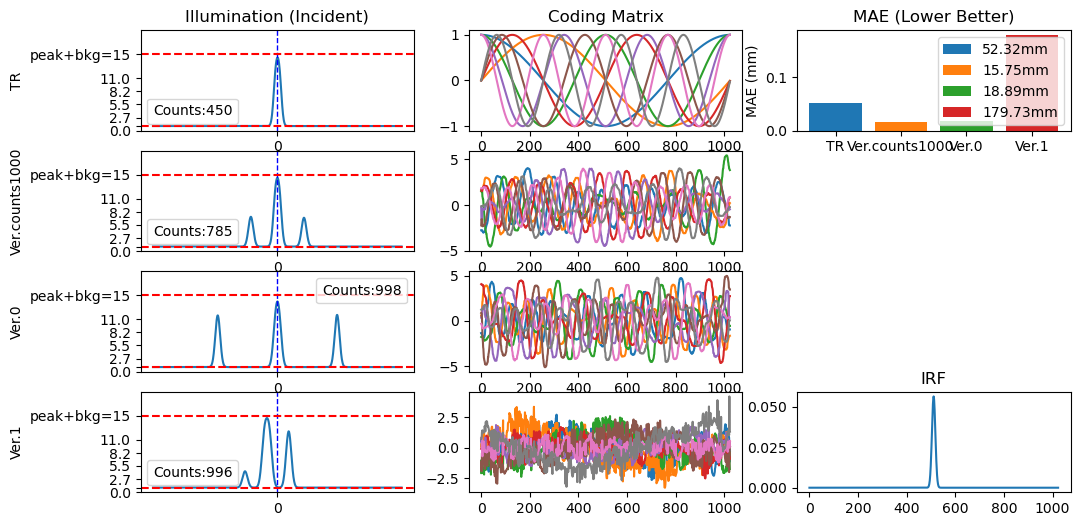

In [6]:
fig, axs = plt.subplots(len(inits), 3, figsize=(12, 6), squeeze=False)
counter = 0
names = []
for init in inits:
    if init.endswith('.ckpt'): 
        get_from_model = True
        with open(os.path.join('experiments/illum_peak_models', init.split('/')[-3], 'hparams.yaml'), 'r') as f:
            hparams = yaml.load(f, Loader=yaml.FullLoader)
            n_tbins_init = hparams['n_tbins']
            k_init = hparams['k']
            recon = hparams['recon']
        name = 'Ver.' + init.split('/')[-3].split('_')[-1]
    else: 
        get_from_model = False
        k_init = k
        n_tbins_init = n_tbins
        name = 'TR'
        recon = 'ifft'

    model = IlluminationPeakLayer(k=k_init, n_tbins=n_tbins_init, init=init, sigma=sigma, get_from_model=get_from_model, peak_factor=peak_factor)

    zncc_layer = ZNCCLayer()
    ifft_layer = IFFTReconLayer(n_tbins_init)

    c_vals = model(depths, peak_counts, ambeints)

    if recon == 'ifft':
        pred_depths = ifft_layer(c_vals)
    elif recon == 'zncc':
        pred_depths = zncc_layer(c_vals, model.cmat1D.weight.data.detach().clone())
    else:
        exit(0)
    
    pred_depths = bin2depth(pred_depths, num_bins=n_tbins_init, tau=rep_tau)
    
    loss = torch.mean(torch.abs(pred_depths.squeeze() - gt_depths.squeeze()))
    #loss = criterion_RMSE(pred_depths, gt_depths)

    print(f'MAE {init.split('/')[-1].split('.')[0]}: {loss * 1000:.3f} mm ')
    names.append(name)
    cmat = model.cmat1D.weight
    cmat = np.transpose(cmat.detach().numpy().squeeze())

    peak_count = peak_factor * counts[0]
    #illum = np.roll(model.illumination.numpy().squeeze(), int(n_tbins_init // 2))
    illum = np.roll(model.get_output_illumination(counts[0], sbrs[0]), int(n_tbins_init // 2))
    sbr_count = float((counts[0] / sbrs[0]) / n_tbins_init)
    axs[counter][0].plot(illum, label=f'Counts:{int(np.sum(illum - sbr_count))}')
    axs[counter][0].axvline(x=int(n_tbins_init // 2), color='blue', linestyle='--', linewidth=1.0)
    axs[counter][0].set_xticks([int(n_tbins_init // 2)])
    axs[counter][0].set_xticklabels([0])
    axs[counter][0].set_yticks(np.append(np.array([sbr_count]), np.append(np.round(np.linspace(0, peak_count+sbr_count-5, 5), 1), np.array([peak_count+sbr_count]))))
    axs[counter][0].set_yticklabels(np.append(np.array(['']), np.append(np.round(np.linspace(0, peak_count+sbr_count-5, 5), 1), np.array([f'peak+bkg={int(peak_count+sbr_count)}']))))
    axs[counter][0].set_ylabel(name)
    axs[counter][0].set_ylim(0, peak_count + sbr_count + 5)
    axs[counter][0].axhline(y=peak_count+sbr_count, color='red', linestyle='--')
    axs[counter][0].axhline(y=sbr_count, color='red', linestyle='--')
    axs[counter][0].legend(handlelength=0, handletextpad=0)
    axs[counter][1].plot(cmat)
    
    #axs[counter][1].set_title(init.split('/')[-1].split('.')[0])

    axs[0][2].bar(counter, loss, label=f'{loss * 1000:.2f}mm')
    axs[0][2].set_title('MAE (Lower Better)')
    axs[0][2].set_ylabel('MAE (mm)')


    axs[0][1].set_title('Coding Matrix')
    axs[0][0].set_title('Illumination (Incident)')

    if counter >= 1 and counter < len(inits)-1:
        axs[counter][2].set_axis_off()
    counter += 1

axs[0][2].set_xticks(np.arange(0, len(inits)))
axs[0][2].set_xticklabels(names)
axs[0][2].legend()

pulse_domain = np.arange(0, n_tbins)
pulse = gaussian_pulse(pulse_domain, mu=pulse_domain[-1] // 2, width=sigma, circ_shifted=True)

axs[-1][2].plot(pulse.squeeze())
axs[-1][2].set_title('IRF')

plt.show(block=True)
